In [35]:
import random

random.seed(10)
b = 100

def generate_x_y(b, accuracy, number_of_trails):
    x_list = []
    y_list = []
    for i in range(number_of_trails):
        x = random.randint(1, 10 * b)
        random_number = random.random() # Unif(0, 1)
        if random_number < accuracy:
            y = x
        else:
            epsilon = random.gauss(0, 500)
            #print(epsilon)
            y = max(1, round(x + epsilon))
            #y = random.randint(1, 5 * b)
        x_list.append(x)
        y_list.append(y)
    #print(x_list)
    #print(y_list)
    return x_list, y_list
        
#generate_x_y(b, 0.5, 10000)


# Deterministic Ski Rental

In [36]:
import math
import numpy as np

def DSR(lambda_, y, b):

    if y < b:
        M = b
    elif y >= b and y <= min(b * (lambda_ + 1) - 1, (b - 1) / lambda_):
        M = y + 1
    else:
        M = math.ceil(lambda_ * b)
    
    return M

def KD(lambda_, y, b):
    if y < b:
        M = math.ceil(b / lambda_)
    else:
        M = math.ceil(lambda_ * b)
        
    return M

In [37]:
def run_experiments_deterministic(lambda_, b, number_of_trails = 10000):
    DSR_ave_CRs = []
    KD_ave_CRs = []
    competitive_ave_CRs = []
    for accuracy in np.arange(0, 1.01, 0.01):
        x_list, y_list = generate_x_y(b, accuracy, number_of_trails)
        DSR_CR_total = 0
        KD_CR_total = 0
        competitive_CR_total = 0
        
        for i in range(number_of_trails):
            x = x_list[i]
            y = y_list[i]
            
            # offline
            offline_optimal_cost = min(x, b)
            
            # DSR
            DSR_M = DSR(lambda_, y, b)
            if DSR_M > x:
                DSR_cost = x
            else:
                DSR_cost = b + DSR_M - 1
            DSR_CR = DSR_cost / offline_optimal_cost
            DSR_CR_total += DSR_CR
                
            # KD
            KD_M = KD(lambda_, y, b)
            if KD_M > x:
                KD_cost = x
            else:
                KD_cost = b + KD_M - 1
            KD_CR = KD_cost / offline_optimal_cost
            KD_CR_total += KD_CR
            
            # competitive
            competitive_M = b
            if competitive_M > x:
                competitive_cost = x
            else:
                competitive_cost = b + competitive_M - 1
            competitive_CR = competitive_cost / offline_optimal_cost
            competitive_CR_total += competitive_CR

        
        DSR_ave_CRs.append(DSR_CR_total / number_of_trails)
        KD_ave_CRs.append(KD_CR_total / number_of_trails)
        competitive_ave_CRs.append(competitive_CR_total / number_of_trails)
        
    return DSR_ave_CRs, KD_ave_CRs, competitive_ave_CRs

DSR_ave_CRs, KD_ave_CRs, det_competitive_ave_CRs = run_experiments_deterministic(0.5, b)

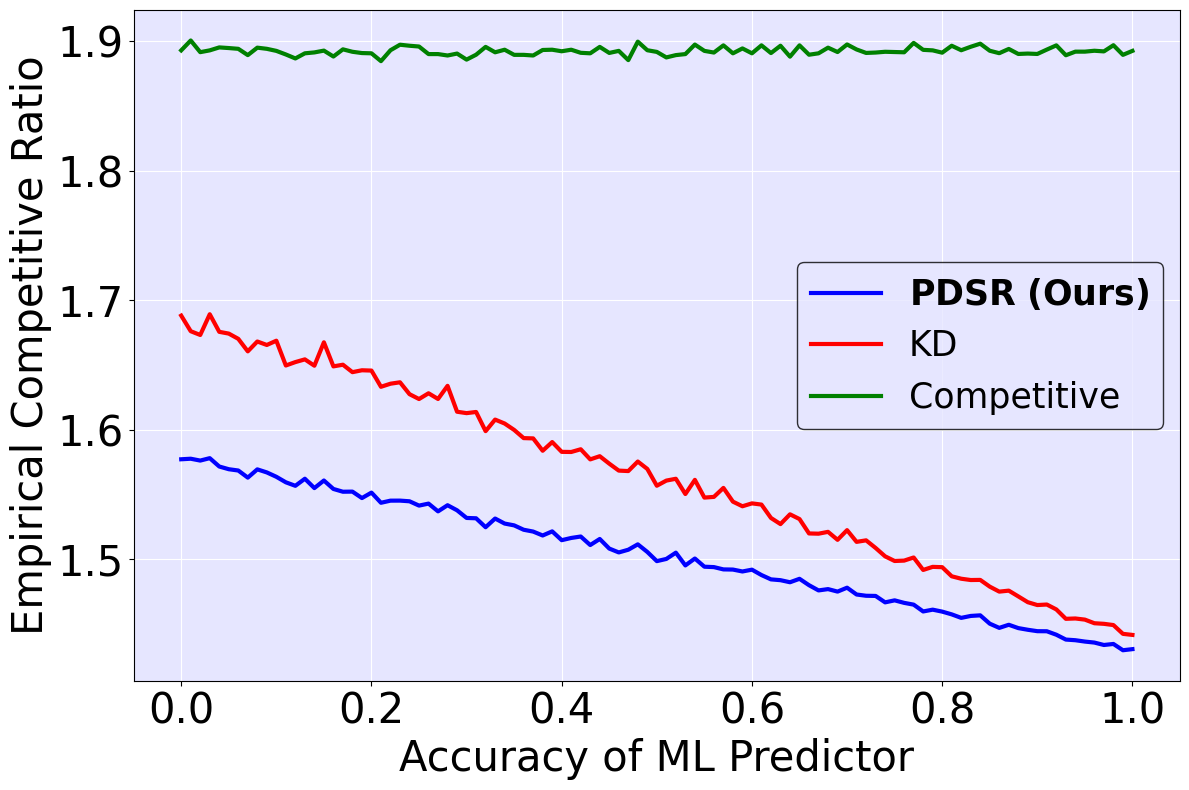

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import os

accuracys = list(np.arange(0, 1.01, 0.01)) 

plt.figure(figsize=(12, 8))

plt.gca().set_facecolor("#e6e6ff")

plt.grid(True, color="white")

plt.plot(accuracys, DSR_ave_CRs, label=r'$\mathbf{PDSR \ (Ours)}$', color="blue", linewidth=3)
plt.plot(accuracys, KD_ave_CRs, label='KD', color="red", linewidth=3)
plt.plot(accuracys, det_competitive_ave_CRs, label='Competitive', color="green", linewidth=3)

plt.xlabel('Accuracy of ML Predictor', fontsize=30)
plt.ylabel('Empirical Competitive Ratio', fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.legend(fontsize=25, frameon=True, facecolor="#e6e6ff", edgecolor="black")

plt.tight_layout()

desktop = os.path.join(os.path.expanduser("~"), "Desktop")
plt.savefig(os.path.join(desktop, "dsr_synthetic.pdf"), format="pdf", facecolor="white")
plt.show()

# Randomized Ski Rental

In [39]:
def kumar_distribution(lambda_, b, y, N=50):
    """
    Generate Kumar's algorithm distribution (Algorithm 3) as a list π[i-1] = π_i
    """
    if y >= b:
        k = int(np.floor(lambda_ * b))
        size = min(k, N)
        dist = []
        denominator = b * (1 - (1 - 1 / b) ** k)
        for i in range(1, size + 1):
            qi = ((b - 1) / b) ** (k - i) * (1 / denominator)
            dist.append((i, qi))
    else:
        l = int(np.ceil(b / lambda_))
        size = min(l, N)
        dist = []
        denominator = b * (1 - (1 - 1 / b) ** l)
        for i in range(1, size + 1):
            ri = ((b - 1) / b) ** (l - i) * (1 / denominator)
            dist.append((i, ri))

    total_prob = sum(p for _, p in dist)
    pi_array = [0.0] * N
    for i, p in dist:
        if i <= N:
            pi_array[i - 1] = p / total_prob
    return pi_array


def equalizing_distribution(m, n, b, total_length=None):
    """
    Generate equalizing distribution π_i^{eq}[m,n] from Theorem 4.2
    Output is list π[i-1] = π_i with length = total_length or n by default
    """
    if m > n:
        raise ValueError("m must be ≤ n")

    ratio = b / (b - 1)
    factor = (m + (b - 1)) / m
    geometric_sum = ratio ** (n - m) - 1
    pi_m = 1 / (1 + factor * geometric_sum)

    dist = []
    for i in range(m, n + 1):
        if i == m:
            pi_i = pi_m
        else:
            pi_i = pi_m * ((m + (b - 1)) / (m * (b - 1))) * (ratio ** (i - m - 1))
        dist.append((i, pi_i))

    # Convert to full list form from i=1 to total_length
    if total_length is None:
        total_length = n
    pi_array = [0.0] * total_length
    for i, p in dist:
        if i <= total_length:
            pi_array[i - 1] = p
    return pi_array

def compute_ratio(pi, x, b):
    """
    Compute R(π, x, b) = [sum_{i=1}^x π_i (i - 1 + b) + sum_{i=x+1}^∞ π_i * x] / min{x, b}
    Input π is a list where π[i-1] = π_i
    """
    pi = np.array(pi)
    n = len(pi)

    # Extend if needed
    if x >= n:
        pi = np.pad(pi, (0, x - n + 10), mode='constant')

    # First part: sum_{i=1}^x π_i * (i - 1 + b)
    part1 = sum(pi[i] * (i + b) for i in range(x))  # i from 0 to x-1 ⇒ i+1 = actual index

    # Second part: sum_{i=x+1}^∞ π_i * x
    part2 = np.sum(pi[x:]) * x

    denom = min(x, b)
    return (part1 + part2) / denom

In [40]:
def operation_A(pi_init, y, b):
    """
    Perform Algorithm 2 (Operation A) using exact linear solution.
    """
    pi = pi_init.copy()
    n = len(pi)
    r = n
    gamma = compute_ratio(pi, 1, b)
    #print(gamma)

    while True:
        if r == 1:
            pi = [0.0] * max(n, b + 2)
            pi[0] = 1 / b
            pi[b] = (b - 1) / b
            return pi

        if r <= y + 1 - b:
            return pi

        # Step 1: merge r into y+1
        pi[y] += pi[r - 1]
        pi[r - 1] = 0

        # Step 2: check ratio
        current_ratio = compute_ratio(pi, y + 1, b)
        #print(r)
        #print(pi[y])
        #print("curr_ratio", current_ratio)
        if current_ratio < gamma:
            r -= 1
            continue

        # Step 3: exact linear solve
        M = 1 - sum(pi[:r - 1])
        S = sum(pi[i] * (i + b) for i in range(r - 1))
        denom = b
        A = r - 1 + b
        B = y + b

        # Solve: (S + x*A + (M - x)*B)/denom = gamma
        # => S + x*A + M*B - x*B = gamma * denom
        # => x*(A - B) = gamma * denom - S - M*B
        num = gamma * denom - S - M * B
        denom_x = A - B
        x = num / denom_x
        y_mass = M - x
        #print(y_mass)

        # Update values
        pi[r - 1] = float(x)
        pi[y] = float(y_mass)
        #print(pi)
        #print("after ratio", compute_ratio(pi, y + 1, b))
        #print("after ratio y", compute_ratio(pi, y, b))
        return pi
    
    import numpy as np
from numpy.linalg import solve, LinAlgError

def compute_ratio_matrix_row(x, b, size):
    row = np.zeros(size)
    minxb = min(x, b)
    for i in range(size):
        if i + 1 <= x:
            row[i] = (i + b) / minxb
        else:
            row[i] = x / minxb
    return row

def build_linear_system_fixed(step, r, y, b, target_gamma=None):
    if step == 1:
        prefix_indices = list(range(1, r + 1))
    else:
        prefix_indices = list(range(1, r)) if r > 1 else []

    suffix_indices = list(range(y + 1, b + 1)) if y + 1 <= b else []
    suffix_len = max(0, b - y)
    total_vars = r + suffix_len

    A = []
    rhs = []

    for x in prefix_indices + suffix_indices:
        row = compute_ratio_matrix_row(x, b, b)
        row_prefix = row[:r]
        row_suffix = row[y:] if y < b else np.array([])
        row_filtered = np.concatenate([row_prefix, row_suffix])
        if step == 1:
            A.append(np.append(row_filtered, -1.0)) 
            rhs.append(0.0)
        else:
            A.append(row_filtered)
            rhs.append(target_gamma)

    norm_row = np.concatenate([
        np.ones(r),
        np.ones(suffix_len)
    ])
    if step == 1:
        A.append(np.append(norm_row, 0.0))
    else:
        A.append(norm_row)
    rhs.append(1.0)

    A = np.array(A)
    rhs = np.array(rhs)
    return A, rhs

def operation_B(y, b, target_gamma, total_length = 100):
    r = 1
    final_solution = equalizing_distribution(y+1, b, b, total_length)

    while True:
        A1, rhs1 = build_linear_system_fixed(step=1, r=r, y=y, b=b)
        #print(A1,rhs1)
        try:
            sol1 = solve(A1, rhs1)
            pi_gamma = sol1[:-1]
            gamma_prime = sol1[-1]
            if gamma_prime <= target_gamma and np.all(pi_gamma >= -1e-8):
                break
        except LinAlgError:
            pass
        if r == y + 1:
            return equalizing_distribution(1, b, b, total_length), r
        r += 1
        #if r > b:
            #raise RuntimeError("Step 1: input gamma is too small")

    A3, rhs3 = build_linear_system_fixed(step=3, r=r, y=y, b=b, target_gamma=target_gamma)
    try:
        sol3 = solve(A3, rhs3)
        #print(A3)
        #print(rhs3)
        if np.any(sol3 < -1e-8):
            print("r", r)
            print("A3", A3)
            print("rhs3", rhs3)
            print("sol3", sol3)
            raise RuntimeError("Step 3: Negative solution occurs")
        final_solution = np.zeros(b)
        final_solution[:r] = sol3[:r]
        final_solution[y:] = sol3[r:]
        final_solution = np.clip(final_solution, 0, 1)
        final_solution /= final_solution.sum()
    except LinAlgError:
        raise RuntimeError("Step 3: There is no solution to the linear system")

    return final_solution, r

import math

def RSR(y, gamma, b, total_length=100):
    e_b = (1 + 1 / (b-1)) ** b
    #print(e_b / (e_b - 1))
    #print(b-3)
    if gamma <= e_b / (e_b - 1):
        gamma = (e_b / (e_b - 1))
    if gamma >= b - 2:
        gamma = b - 2 - 1e-8
    n = math.ceil(math.log(1 + 1 / (gamma - 1), b /(b-1)))
    if y >= b:
        pi = operation_A(equalizing_distribution(1, n, b, total_length), y, b)
    elif y < b:
        gamma_rec = ((b/(b-1)) ** n - 1) ** (-1) + 1
        lower = compute_ratio(equalizing_distribution(1, b, b, total_length), 1, b)
        upper = compute_ratio(equalizing_distribution(y+1, b, b, total_length), b, b)
        #if gamma_rec < lower:
            #gamma_rec = lower + 1e-8
        
        if gamma_rec > upper:
            gamma_rec = upper
        #print(lower)
        #print("gamma_rec:", gamma_rec)
        pi = operation_B(y, b, gamma_rec)[0]
    return pi

In [41]:
import math

def run_experiments_randomized(lambda_, gamma, b, number_of_trails = 10000):
    RSR_ave_CRs = []
    KR_ave_CRs = []
    competitive_ave_CRs = []
    for accuracy in np.arange(0, 1.01, 0.01):
        x_list, y_list = generate_x_y(b, accuracy, number_of_trails)
        RSR_CR_total = 0
        KR_CR_total = 0
        competitive_CR_total = 0
        
        for i in range(number_of_trails):
            x = x_list[i]
            y = y_list[i]
            
            # offline
            offline_optimal_cost = min(x, b)
            
            # RSR
            total_length = max(math.floor(b / lambda_), y) + 10
            RSR_pi = RSR(y, gamma, b, total_length)
            RSR_CR = compute_ratio(RSR_pi, x, b)
            RSR_CR_total += RSR_CR
                
            # KR
            KR_pi = kumar_distribution(lambda_, b, y, total_length)
            KR_CR = compute_ratio(KR_pi, x, b)
            KR_CR_total += KR_CR
            
            # competitive
            competitive_pi = kumar_distribution(1, b, y, total_length)
            competitive_CR = compute_ratio(competitive_pi, x, b)
            competitive_CR_total += competitive_CR

        
        RSR_ave_CRs.append(RSR_CR_total / number_of_trails)
        KR_ave_CRs.append(KR_CR_total / number_of_trails)
        competitive_ave_CRs.append(competitive_CR_total / number_of_trails)
        
    return RSR_ave_CRs, KR_ave_CRs, competitive_ave_CRs

RSR_ave_CRs, KR_ave_CRs, rand_competitive_ave_CRs = run_experiments_randomized(math.log(3 / 2), 3, b, number_of_trails = 10000)

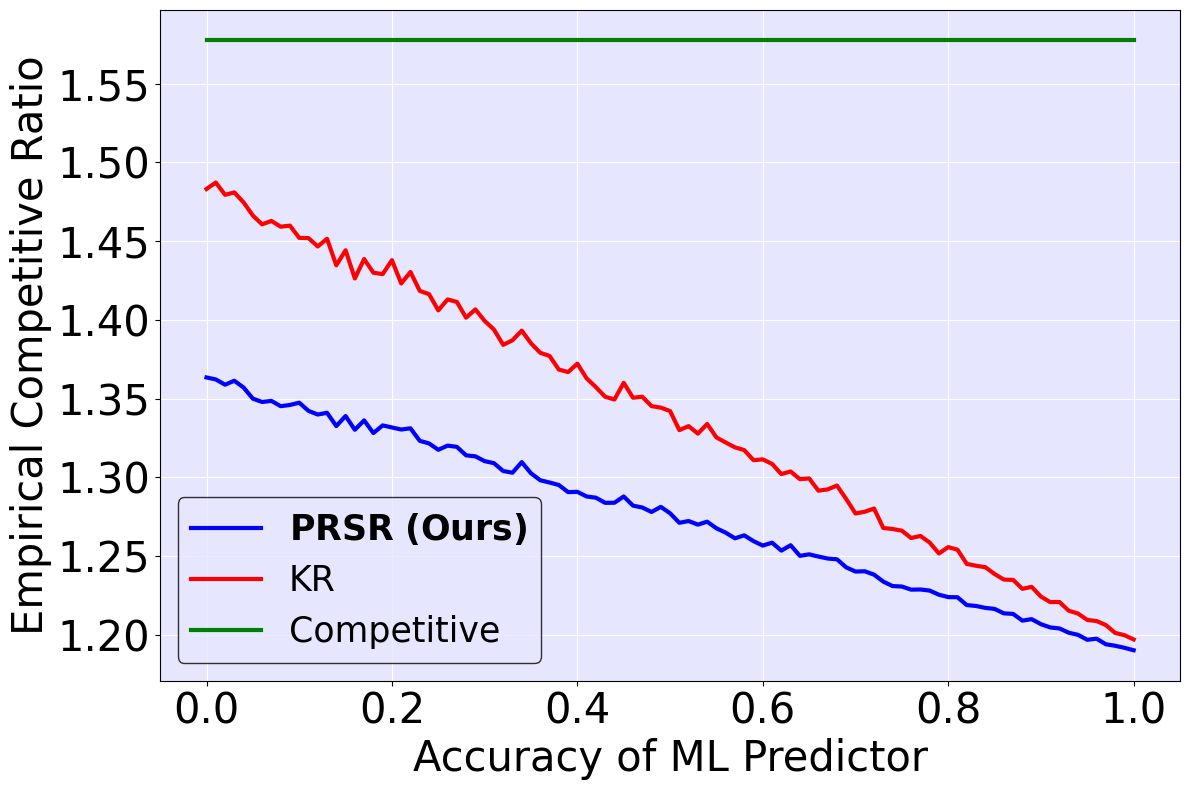

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import os

accuracys = list(np.arange(0, 1.01, 0.01)) 

plt.figure(figsize=(12, 8))

plt.gca().set_facecolor("#e6e6ff")

plt.grid(True, color="white")

plt.plot(accuracys, RSR_ave_CRs, label=r'$\mathbf{PRSR \ (Ours)}$', color="blue", linewidth=3)
plt.plot(accuracys, KR_ave_CRs, label='KR', color="red", linewidth=3)
plt.plot(accuracys, rand_competitive_ave_CRs, label='Competitive', color="green", linewidth=3)

plt.xlabel('Accuracy of ML Predictor', fontsize=30)
plt.ylabel('Empirical Competitive Ratio', fontsize=30)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.legend(fontsize=25, frameon=True, facecolor="#e6e6ff", edgecolor="black")

plt.tight_layout()

desktop = os.path.join(os.path.expanduser("~"), "Desktop")
plt.savefig(os.path.join(desktop, "rsr_synthetic.pdf"), format="pdf", facecolor="white")
plt.show()